# Core-hole localization
A special aspect of X-ray spectroscopy calculations which involve an explicit core-hole, e.g. X-ray photoelectron spectroscopy (XPS) or X-ray emission spectroscopy (XES), is the delocalization-induced relaxation error (DIRE) {cite}`dire2022`. DIRE affects symmetric molecules where care must be taken to localize the core-hole, especially when HF or DFT theory levels are used. Below follows an illustration of DIRE in the case of the ethylene molecule. We will calculate the ionization energy of the C 1s core orbitals. The ionization energy is calculated as:

$$
\textrm{IE} = E_\textrm{FCH} - E_\textrm{GS}
$$

We will have to perform a ground state calculation, as well as a calculation with a full core-hole (FCH) on the C 1s orbital. The FCH is obtained using the [maximum overlap method (MOM)](sec:xray_mom). One option to localize the core-hole is to replace the 1s electrons of the non-core-ionized C atom with an effective core potential (ECP). Another option is to very slightly distort the molecule, which is the approach adopted here.

In [1]:
import veloxchem as vlx
from veloxchem.veloxchemlib import hartree_in_ev
import py3Dmol as p3d
from matplotlib import pyplot as plt
import numpy as np
import copy
import k3d

In [2]:
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    """
    Lorentzian broadening function

    Call: xi,yi = lorentzian(energies, intensities, start energy,
                                    end energy, energy step, gamma)
    """
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = (
                yi[i]
                + y[k] * gamma / ((xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2) / np.pi
            )
    return xi, yi

def plot_orbital(molecule, basis, scf_drv, orbital_index=0):
    """ Uses the OrbitalViewer class to plot one orbital.

        :param molecule: the molecule.
        :param basis: the basis set.
        :param scf_drv: the SCF driver.
        :param orbital_index: the index of the orbital.
    """
    orb_viewer = vlx.OrbitalViewer()

    mo_object = scf_drv.mol_orbs
    orb_viewer._is_uhf = False
    orb_viewer._mo_coefs = mo_object.alpha_to_numpy()

    orb_viewer.initialize(molecule, basis)

    orb_viewer._this_plot = k3d.plot(grid_visible=False)
    plt_atoms, plt_bonds = orb_viewer.draw_molecule(molecule)
    orb_viewer._this_plot += plt_atoms
    for bonds in plt_bonds:
        orb_viewer._this_plot += bonds

    orbital = orb_viewer.compute_orbital(orb_viewer._mo_coefs, orbital_index)
    orb_viewer._plt_iso_one, orb_viewer._plt_iso_two = orb_viewer.draw_orbital(orbital)
    orb_viewer._this_plot += orb_viewer._plt_iso_one
    orb_viewer._this_plot += orb_viewer._plt_iso_two
    orb_viewer._this_plot.display()

##  Step 1 $-$ Define the molecular geometries

In the following, we will create two ethylene molecules, one fully symmetric to obtain delocalized C 1s core orbitals and and one with slightly stretched CH bonds at one of the C sites, to obtain localized C 1s core orbitals.

In [3]:
deloc_ethylene_xyz = """6
symmetric ehtylene molecule
C   0.666005   0.000000   0.000000
C  -0.666005   0.000000   0.000000
H   1.227874   0.922836   0.000000
H   1.227874  -0.922836   0.000000
H  -1.227874   0.922836   0.000000
H  -1.227874  -0.922836   0.000000
"""

loc_ethylene_xyz = """6
asymmetric ethylene molecule to localize the C1s orbitals
C   0.666005   0.000000   0.000000
C  -0.666005   0.000000   0.000000
H   1.227874   0.922836   0.000000
H   1.227874  -0.922836   0.000000
H  -1.2538762  0.965543   0.000000    
H  -1.2538762 -0.965543   0.000000   
"""

basis_set_label = "6-311++G_D,P_" #"DEF2-TZVPPD" #"TAUG-CC-PCVDZ" #

deloc_ethylene = vlx.Molecule.from_xyz_string(deloc_ethylene_xyz)
loc_ethylene = vlx.Molecule.from_xyz_string(loc_ethylene_xyz)

basis = vlx.MolecularBasis.read(loc_ethylene, basis_set_label)

In [4]:
viewer = p3d.view(viewergrid=(1, 2), width=600, height=250, linked=True)
print("   (a) Symmetric ethylene            (b) Ethylene CH bonds on one C stretched by 0.05 Å")
viewer.addModel(deloc_ethylene_xyz, "xyz", viewer=(0, 0))
viewer.addModel(loc_ethylene_xyz, "xyz", viewer=(0, 1))
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
viewer.zoomTo()
viewer.show()

   (a) Symmetric ethylene            (b) Ethylene CH bonds on one C stretched by 0.05 Å


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Step 2 $-$ determine the ground state energy

In [5]:
deloc_scf_drv = vlx.ScfRestrictedDriver()
deloc_scf_drv.ostream.mute()
deloc_scf_results = deloc_scf_drv.compute(deloc_ethylene, basis)

In [6]:
loc_scf_drv = vlx.ScfRestrictedDriver()
loc_scf_drv.ostream.mute()
loc_scf_results = loc_scf_drv.compute(loc_ethylene, basis)

In [7]:
plot_orbital(deloc_ethylene, basis, deloc_scf_drv, orbital_index=0)

Output()

In [8]:
plot_orbital(loc_ethylene, basis, loc_scf_drv, orbital_index=0)

Output()

## Step 3 $-$ determine the core-ionized state energy

In [9]:
def compute_fch_energy(molecule, basis, scf_drv):
    fch_molecule = copy.deepcopy(molecule)
    fch_molecule.set_charge(1)
    fch_molecule.set_multiplicity(2)

    # Lists of occupied alpha and beta MOs
    occ_alpha = [0, 1, 2, 3, 4, 5, 6, 7]
    occ_beta  = [1, 2, 3, 4, 5, 6, 7]

    # Calculate SCF of the core-ionized system using the maximum overlap method
    scfdrv_fch = vlx.ScfUnrestrictedDriver()
    scfdrv_fch.ostream.mute()
    scfdrv_fch.maximum_overlap(fch_molecule, basis, scf_drv.mol_orbs,
                               occ_alpha, occ_beta)
    scf_results = scfdrv_fch.compute(fch_molecule, basis)

    return scfdrv_fch.get_scf_energy()

$$
\textrm{IE} = E_\textrm{FCH} - E_\textrm{GS}
$$

In [10]:
deloc_fch_energy = compute_fch_energy(deloc_ethylene, basis, deloc_scf_drv)
deloc_gs_energy = deloc_scf_drv.get_scf_energy()
deloc_hf_ie = (deloc_fch_energy - deloc_gs_energy) * hartree_in_ev()

# Add a Lorentzian broadening
deloc_x, deloc_y = lorentzian(np.array([deloc_hf_ie]), np.array([1]), 
                              deloc_hf_ie - 5, deloc_hf_ie + 5, 0.01, 0.7)

In [11]:
loc_fch_energy = compute_fch_energy(loc_ethylene, basis, loc_scf_drv)
loc_gs_energy = loc_scf_drv.get_scf_energy()
loc_hf_ie = (loc_fch_energy - loc_gs_energy) * hartree_in_ev()

loc_x, loc_y = lorentzian(np.array([loc_hf_ie]), np.array([1]), 
                          loc_hf_ie - 5, loc_hf_ie + 5, 0.01, 0.7)

Now that we have calculated the ionization energies for both the localized and delocalized CH, let us plot the results. The dotted line marks the measured ionization energy {cite}`xpsethylene2011`.

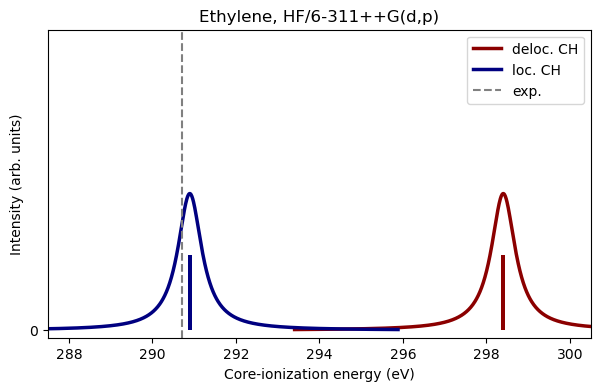

In [12]:
plt.figure(figsize=(7, 4))

plt.bar(deloc_hf_ie, 1.0, color="darkred", width=0.1)
plt.bar(loc_hf_ie, 1.0, color="navy", width=0.1)
plt.plot(deloc_x, deloc_y, color="darkred", label="deloc. CH", linewidth=2.5)
plt.plot(loc_x, loc_y, color="navy", label="loc. CH", linewidth=2.5)

plt.xlabel("Core-ionization energy (eV)")
plt.ylabel("Intensity (arb. units)")
plt.title("Ethylene, HF/6-311++G(d,p)")

plt.axvline(290.7, linestyle="--", color="gray", label="exp.")
plt.axis(xmin=287.5, xmax=300.5, ymin=-0.1, ymax=4.0)

plt.xticks([288, 290, 292, 294, 296, 298, 300])
plt.yticks([0])

plt.legend()
plt.show()

In [13]:
print("DIRE, HF XPS: %.2f eV" % (deloc_hf_ie - loc_hf_ie) )

DIRE, HF XPS: 7.51 eV
